# Обнаружение улыбки на изображениях лиц

## Загрузка пакетов

Загрузим необходимые пакеты.

In [7]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import h5py

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

## 1 - Отслеживание Эмоций


Для построения и обучия модели есть фотографии лиц некоторых добровольцев. Набор данных помечен.

<img src="images/face_images.png" style="width:700px;height:300px;">

In [9]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [78]:
# Загрузка данных
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Нормализация векторов изображений
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Изменение формы
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print("Количество фото для обучения = " + str(X_train.shape[0]))
print("Количество фото для теста = " + str(X_test.shape[0]))
print("X_train размерность: " + str(X_train.shape))
print("Y_train размерность: " + str(Y_train.shape))
print("X_test размерность: " + str(X_test.shape))
print("Y_test размерность: " + str(Y_test.shape))

Количество фото для обучения = 600
Количество фото для теста = 150
X_train размерность: (600, 64, 64, 3)
Y_train размерность: (600, 1)
X_test размерность: (150, 64, 64, 3)
Y_test размерность: (150, 1)


- Изображения имеют форму (64, 64, 3) - цветные изображения с размерностью 64x64

Посмотрим на некоторые данные из обучающей выборки.

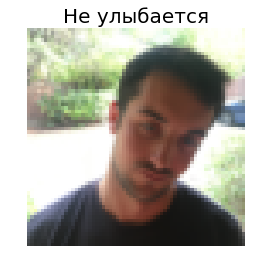

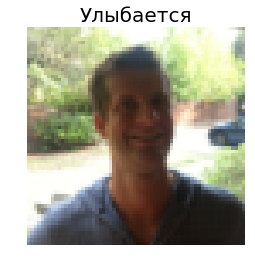

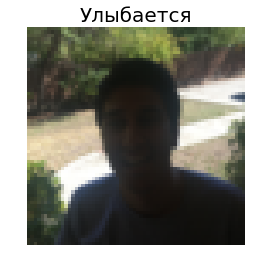

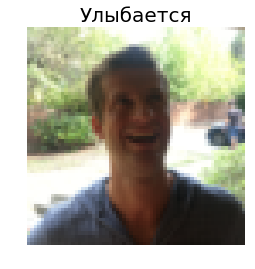

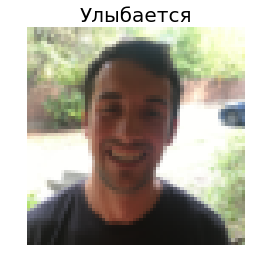

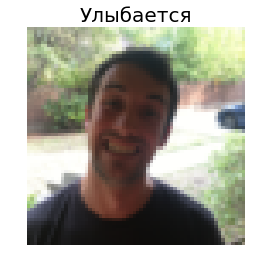

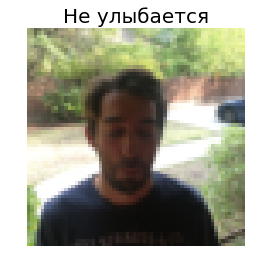

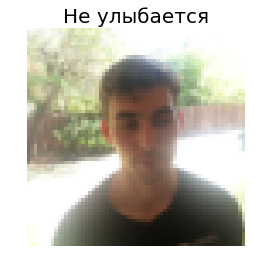

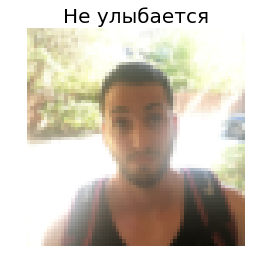

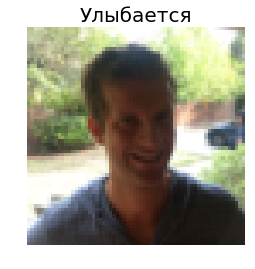

In [21]:
for i in range(10):
    plt.imshow(X_train[i])
    plt.title(['Не улыбается', 'Улыбается'][Y_train[i][0]], fontsize=20)
    plt.axis('off')
    plt.show()

## 2 - Построение модели в Keras

Keras очень хорош для быстрого прототипирования. Всего за короткое время мы можем построить модель, которая достигнет выдающихся результатов.

Вот пример модели в Керасе:

```python
def model(input_shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Определение входного placeholder как тензор с формой input_shape.
    X_input = Input(input_shape)

    # Zero-Padding: заполняет границу X_input нулями
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU блок применяется к X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (преобразование в вектор) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Создание экземпляра модели Keras для использовая его при обучении / тестировании.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

#### Соглашение об именовании переменных

* Keras использует другое соглашение с именами переменных, в отличии от numpy и TensorFlow.
* Вместо создания уникальных имен переменных для каждого шага и каждого слоя, таких как
```python
X = ...
А1 = ...
B1 = ...
```
* Keras повторно использует и перезаписывает одну и ту же переменную на каждом шаге:
```python
X = ...
X = ...
X = ...
```
* Исключение составляет `X_input`, который сохраняется отдельно, так как он понадобится позже.

#### Объекты как функции
* В каждой строке есть две пары скобок. Например:
```python
X = ZeroPadding2D((3, 3))(X_input)
```
* Первая пара скобок - это вызов конструктора, который создает объект (`Zeropadding2n`).
* Вторая пара скобок - это обращение к экземпляру `Zeropadding2n` как функции с передачей `X_input` в качестве аргумента.
* Данная строка эквивалентна этому:
```python
ZP = ZeroPadding2D((3, 3)) # ZP - это объект, который может быть вызван как функция
Х = ZP(X_input)
```

In [22]:
def HappyModel(input_shape):
    """
    Реализация HappyModel.
    
    Arguments:
    input_shape -- форма изображений набора данных
        (высота, ширина, количество каналов) как tuple.  

    Returns:
    model -- Model() экземпляра в Keras
    """
    
    X_input = Input(input_shape)

    # Добавление границы из 3 нулей.
    X = ZeroPadding2D((3, 3))(X_input)
    # Сверточный слой, Размер ядра: 7x7, strides: 1x1.
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    # Нормализация батча после свертки по каналам.
    X = BatchNormalization(axis=3, name='bn0')(X)
    # Активация ReLU
    X = Activation('relu')(X)
    # Max Pooling 2x2.
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # Выход в виде вектора
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Окончательная модель
    model = Model(inputs=X_input, outputs=X, name='HappyModel')
    
    return model

#### Шаг 1: Создание экземпляра модели.

In [23]:
happyModel = HappyModel(input_shape=(64, 64, 3))

#### Шаг 2: Компиляция модели

In [24]:
happyModel.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

Посмотрим на архитектуру модели

In [35]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

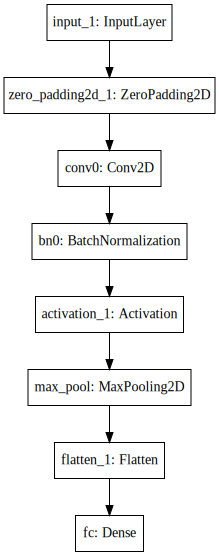

In [36]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))

#### Шаг 3: Обучение модели

In [25]:
happyModel.fit(x=X_train, y=Y_train, batch_size=60, epochs=60)

Epoch 1/60
600/600 [==============================] - 12s - loss: 3.3074 - acc: 0.4967    
Epoch 2/60
600/600 [==============================] - 12s - loss: 0.9756 - acc: 0.6983    
Epoch 3/60
600/600 [==============================] - 13s - loss: 0.3309 - acc: 0.8383    
Epoch 4/60
600/600 [==============================] - 13s - loss: 0.1993 - acc: 0.9250    
Epoch 5/60
600/600 [==============================] - 13s - loss: 0.1780 - acc: 0.9350    
Epoch 6/60
600/600 [==============================] - 13s - loss: 0.1396 - acc: 0.9583    
Epoch 7/60
600/600 [==============================] - 12s - loss: 0.1345 - acc: 0.9517    
Epoch 8/60
600/600 [==============================] - 13s - loss: 0.1250 - acc: 0.9500    
Epoch 9/60
600/600 [==============================] - 13s - loss: 0.1283 - acc: 0.9483    
Epoch 10/60
600/600 [==============================] - 13s - loss: 0.1068 - acc: 0.9633    
Epoch 11/60
600/600 [==============================] - 13s - loss: 0.0805 - acc: 0.9800  

#### Шаг 4: Оценка работы модели

In [26]:
preds = happyModel.evaluate(x=X_test, y=Y_test, batch_size=150)
print()
print ("Значение Loss = " + str(preds[0]))
print ("Точность на тестовой выборке = " + str(preds[1]))

150/150 [==============================] - 1s

Значение Loss = 0.0785434097052
Точность на тестовой выборке = 0.966666638851


## 3 - Тестирование на собственных изображениях
 

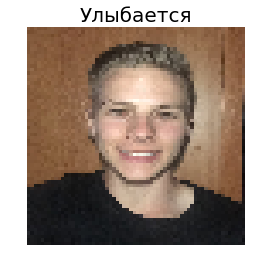

In [117]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)/255.
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.axis('off')
plt.title(['Не улыбается', 'Улыбается'][int(happyModel.predict(x)[0][0])], 
          fontsize=20);

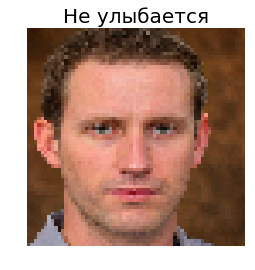

In [118]:
img_path = 'images/my_image_2.jpg'
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)/255.
x = np.expand_dims(x, axis=0)

plt.axis('off')
plt.title(['Не улыбается', 'Улыбается'][int(happyModel.predict(x)[0][0])], 
          fontsize=20);